# Set Up

## Introduction

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

**Note**: computationally exhaustive model fits are commented out. The pre-trained models are loaded in via pickle as long as they are downloaded and placed in the correct folder. See `README.md` for more.

To do:
- Comment
- Push final state to git
- Finish Presentation

## Packages

In [1]:
#trifecta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#gen process
from copy import deepcopy
from sklearn.model_selection import train_test_split

#NLP process
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

#Models
from sklearn import naive_bayes
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#export model
import pickle

#Evaluation
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV

In [37]:
#pull custom NLP pre-processing functions
%run -i NLP_functions.py

## Data

In [3]:
#download data
data_raw = pd.read_csv('../big_files/train.csv')
data_raw.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
#drop id col (dup of index)
data_raw = data_raw.drop(['id', 'qid1', 'qid2'], axis = 1) #[don't think I need qid but I'd like to check that]

# Exploration

In [5]:
#get frequency for class (is/isnt duplicate)
class_freq = data_raw.groupby('is_duplicate').count().question1

class_freq/ data_raw.shape[0] #roughly 60:40 ratio, in interest of time we'll say this is fine

is_duplicate
0    0.630800
1    0.369198
Name: question1, dtype: float64

In [6]:
data_raw.info() #nulls & dtype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   question1     404289 non-null  object
 1   question2     404288 non-null  object
 2   is_duplicate  404290 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 9.3+ MB


In [7]:
#missing values
data_raw.isnull().sum()

question1       1
question2       2
is_duplicate    0
dtype: int64

In [8]:
#explore the nan
data_raw[data_raw.isnull().any(axis=1)]

,question1,question2,is_duplicate
105780,How can I develop android app?,NaN,0
201841,How can I create an Android app?,NaN,0
363362,NaN,My Chinese name is Haichao Yu. What English na...,0


In [9]:
data_raw = data_raw.dropna() #drop nan

In [10]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404287 entries, 0 to 404289
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   question1     404287 non-null  object
 1   question2     404287 non-null  object
 2   is_duplicate  404287 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 12.3+ MB


# Cleaning and Feature Extraction

## NLP Pre-Processing

In [11]:
#create deep copy of data to change
X = deepcopy(data_raw)

In [12]:
#clean, stem and tokenize each column of strings
X['question1'] = process_features(X['question1']) #with such a big frame this takes a while
X['question2'] = process_features(X['question2'])

In [13]:
#seperate sentences from target
y = X.is_duplicate
X = X.drop('is_duplicate', axis=1)

X.head() #check

,question1,question2
0,"[step, step, guid, invest, share, market, india]","[step, step, guid, invest, share, market]"
1,"[stori, kohinoor, kohinoor, diamond]","[would, happen, indian, govern, stole, kohinoo..."
2,"[increas, speed, internet, connect, use, vpn]","[internet, speed, increas, hack, dn]"
3,"[mental, lone, solv]","[find, remaind, math, math, divid]"
4,"[one, dissolv, water, quikli, sugar, salt, met...","[fish, would, surviv, salt, water]"


## Similarity

In [14]:
#use custome function to create similarity score
X['similarity'] = similarity_score(X) #apply to X

In [15]:
#split before we are doing fit /transform operation
#test train split, also split out labels (y)
X_train, X_test, y_train, y_test = train_test_split(X[['question1', 'question2', 'similarity']], y, stratify = y, random_state = 42) #default of 20%

## Vectorize

In [16]:
#Vectorize
#so it can handle token data we add this dummy function
def dummy_fun(doc):
    return doc

#instansiate vectorizer
vectorizer = TfidfVectorizer(max_features = 2500, min_df = 7, tokenizer=dummy_fun,
                            preprocessor=dummy_fun, max_df = 0.8, stop_words = stopwords.words('english'))
    
#fit to the entire corpus (question 1 and 2)
vectorizer.fit(X_train[['question1', 'question2']].values.flatten())

C:\Users\fynn\Documents\anaconda\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\fynn\Documents\anaconda\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  warnings.warn(


TfidfVectorizer(max_df=0.8, max_features=2500, min_df=7,
                preprocessor=<function dummy_fun at 0x000001078E9ACA60>,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function dummy_fun at 0x000001078E9ACA60>)

In [17]:
#use custom functions to get vectors and merge with similarity for single feature input
X_train_features = vectors_to_features(X_train)
X_test_features = vectors_to_features(X_test)

#check the input shape of the data
print(X_train_features.shape)
print(y_train.shape)

(303215, 5001)
(303215,)


# Modelling

## Initial Test with RFC

In [18]:
#create dataframe to compare scores
comparison_train = pd.DataFrame(index = ['RandomForest', 'LogReg', 'NaiveBayes'], columns = ['recall', 'precision', 'accuracy'])
comparison_test = pd.DataFrame(index = ['RandomForest', 'LogReg', 'NaiveBayes'], columns = ['recall', 'precision',  'accuracy'])

In [19]:
#Train random forest
#rfc = RandomForestClassifier(random_state = 1)
#rfc.fit(X_train_features, y_train)

In [20]:
#save the trained model
#pickle.dump(rfc, open('rfc_default.sav', 'wb'))

#load trained model
rfc_default = pickle.load(open('../big_files/rfc_default.sav', 'rb'))

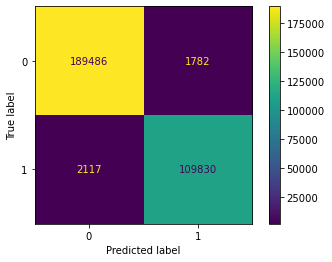

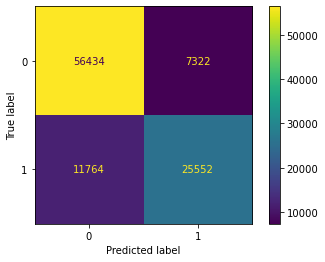

In [42]:
#create predictions
y_rfc_train = rfc_default.predict(X_train_features)
y_rfc_test = rfc_default.predict(X_test_features)

#save predictions to comparison dataframe
comparison_train.loc['RandomForest'] = evaluation(y_rfc_train, y_train, save='rfc_default_train')
comparison_test.loc['RandomForest'] = evaluation(y_rfc_test, y_test,save= 'rfc_default_test')

In [22]:
rfc_default.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

## Other Shallow Models

In [24]:
import numpy as np
import random

def set_random_seed(seed=0):
    np.random.seed(seed)
    random.seed(seed)

In [25]:
#train naive bayes
set_random_seed(1)
naive = naive_bayes.MultinomialNB()
naive.fit(X_train_features, y_train)

#train logreg
lr = LogisticRegression(random_state = 1)
lr.fit(X_train_features, y_train)

C:\Users\fynn\Documents\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=1)

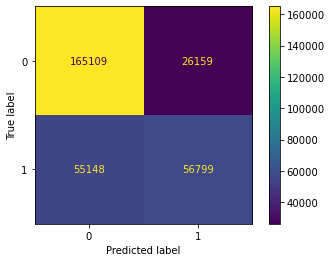

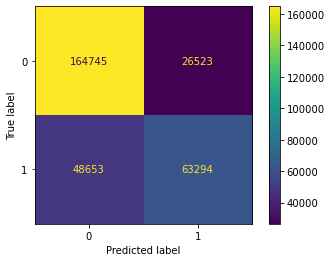

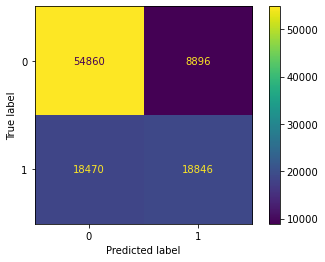

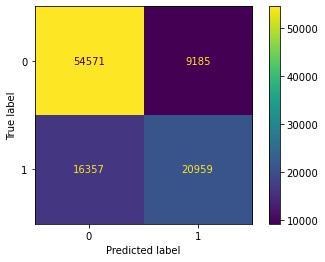

In [40]:
#create predictions
y_naive_train = naive.predict(X_train_features)
y_lr_train = lr.predict(X_train_features)

y_naive = naive.predict(X_test_features)
y_lr = lr.predict(X_test_features)

#add to comparison dataframes
comparison_train.loc['NaiveBayes'] = evaluation(y_naive_train, y_train, 'naive_train')
comparison_train.loc['LogReg'] = evaluation(y_lr_train, y_train, 'lr_train')
comparison_test.loc['NaiveBayes'] = evaluation(y_naive, y_test, 'naive_test')
comparison_test.loc['LogReg'] = evaluation(y_lr, y_test, 'lr_test')

## Gridsearch

In [27]:
#define hyperparameters to try
param_grid = {'max_features': ['auto', 'log2', 'sqrt'],
              'min_samples_leaf': [ 5, 10, 20]}

#Instantiate random forest with specific parameters
rfc_grid = RandomForestClassifier(random_state = 1, n_jobs = -1, n_estimators = 1000, oob_score = True)
#instantiant gridsearch with random forest and param grid
gridsearch = GridSearchCV(rfc_grid, param_grid, n_jobs = -1, verbose = 1)

In [ ]:
#-- TAKES ROUGHLY 4 HOURS --
#gridsearch.fit(X_train_features, y_train)

In [28]:
#save the trained model
#pickle.dump(gridsearch, open('rfc_grid.sav', 'wb'))

#load trained model
gridsearch_saved = pickle.load(open('../big_files/rfc_grid.sav', 'rb'))
#what params did it choose
gridsearch_saved.best_params_

{'max_features': 'auto', 'min_samples_leaf': 5}

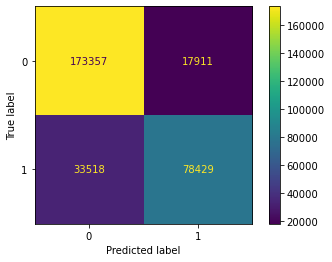

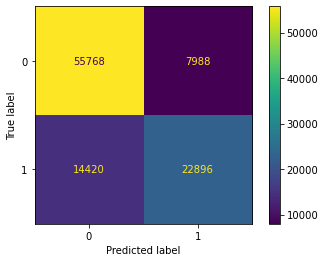

In [41]:
grid_train = gridsearch_saved.predict(X_train_features)
grid_test = gridsearch_saved.predict(X_test_features)

comparison_train.loc['RandomForestGrid'] = evaluation(grid_train, y_train, 'rfc_grid_train')
comparison_test.loc['RandomForestGrid'] = evaluation(grid_test, y_test, 'rfc_grid_test')

In [30]:
comparison_train #show train comparison

,recall,precision,accuracy
RandomForest,0.984034,0.981089,0.987141
LogReg,0.7047,0.565393,0.75207
NaiveBayes,0.684672,0.507374,0.73185
RandomForestGrid,0.814086,0.70059,0.830388


In [31]:
comparison_test #show test comparison

,recall,precision,accuracy
RandomForest,0.777271,0.684746,0.811164
LogReg,0.695296,0.561663,0.747289
NaiveBayes,0.679331,0.505038,0.729243
RandomForestGrid,0.741355,0.613571,0.778297
